# Blind Source Separations


## Introduction
How can you determine how many people are talking in a room at a party? It's a [challenging problem](https://en.wikipedia.org/wiki/Source_separation) and the basic premise of the problems creeps up in a lot of different fields.

In my own field, EEG is a perfect example of trying to "unmix" signals to find out what I actually measured. Scalp EEG is highly correlated, with a single brain source being "smeared" across multiple channels.

Blind source separation is the problem of trying to split out independent processes that are generating data. Doing this without a priori information about the system/s generating the data is the "blind" part of this.

A common example of this type of problem is trying to identify the number of people speaking in a noisy room with a certain number of microphones. Each microphone picks up each speaker, but to varying degrees. With information about where the microphones are, this problem is not so "blind". Without information about where the microphones are, this problem becomes "blind", but not insurmountable.

## Generate our data
We know the properties that our data needs:

* Gaussian with noise
* Multimodal

Since we'll be dealing with timeseries in other notebooks, we'll focus our conversation around timeseries knowing that the principles are generalizable.

In [113]:
%reset
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as sig

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


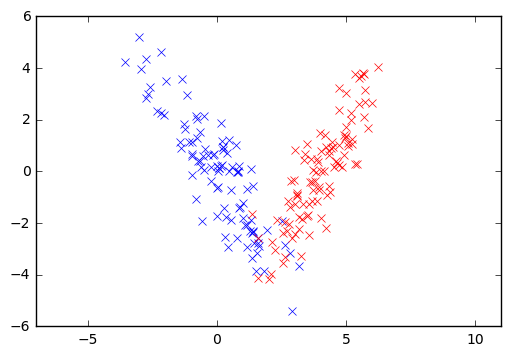

In [114]:
#We'll deal with 2D data

#Simple cross example
mean1 = [0,0]
cov1 = [[0,0.7],[-3.5,6]]
cov2 = [[0,-0.7],[3.5,6]]
mean2 = [4,0]
x,y = np.random.multivariate_normal(mean1,cov1,100).T
u,v = np.random.multivariate_normal(mean2,cov2,100).T

plt.plot(x,y,'x')
plt.plot(u,v,'x',color='r')
plt.axis('equal')
plt.show()

We made a dataset where two independent processes are observed. We know it's two independent processes because we *made them from scratch using two separate function calls to multivariate normal*. Of course, since it's all pseudorandom number generation, might have to make sure the seeds are different for each call, but I'm not sure that's how it's supposed to work.

We have a dataset with two independent processes. We want to now study this and *find* these processes from data where we won't know where each datapoint is actually coming from.

This set is actually very easy to see *visually* but let's do the process from the ground up. We start with linear approaches, move to ICA, then to gaussian processes.

### Principle Component Analysis
First we'll do a PCA on the aggregate dataset. This will give us two components: a component in the direction of maximal variance, and another one orthogonal to that

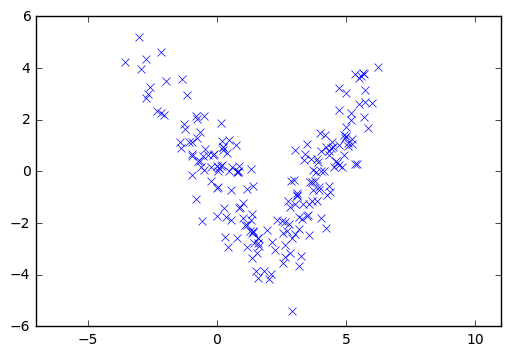

In [115]:
data = np.vstack((np.hstack((x,u)),np.hstack((y,v))))
plt.plot(data[0,:],data[1,:],'x')
plt.axis('equal')
plt.show()

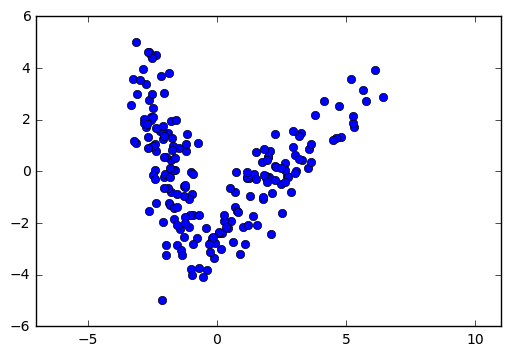

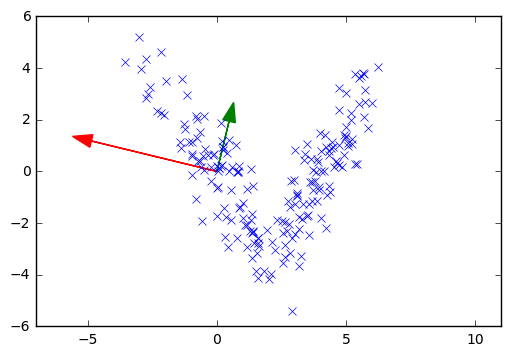

In [116]:
from sklearn.decomposition import PCA as sklPCA

def do_PCA(data):
    skl_PCA = sklPCA(n_components=2)
    skl_Xform = skl_PCA.fit_transform(data.T)

    plt.plot(skl_Xform[:,0],skl_Xform[:,1],'o')
    plt.axis('equal')
    plt.show()

    pcs = skl_PCA.components_

    plt.figure()
    ax=plt.axes()

    plt.plot(data[0,:],data[1,:],'x')
    ax.arrow(0,0,5*pcs[0,0],5*pcs[1,0],color='r',head_width=0.5)
    ax.arrow(0,0,2*pcs[0,1],2*pcs[1,1],color='g',head_width=0.5)
    #plt.plot(pcs[0,:])
    plt.axis('equal')
    plt.show()
    
do_PCA(data)

So, according to PCA, we've got two components in our data. One going in the red direction, the other going in the green direction. We know this isn't true, we don't have a single linear system in 2D that maps inputs to outputs. So PCA completely misses the mark on this.

A next step, if we didn't know what we knew about the source of our data, would be to look at the eigenvalues for each component. This would give us an idea of how much of the data variance is "explained" by that component. The red would be higher, by definition, but the green would account for a sizable portion.

#### Outliers
In some cases, we can actually see how sensitive PCA is to even a single outlier. Let's add a single point to the above dataset at (2,-6) and see how the principle components shift.

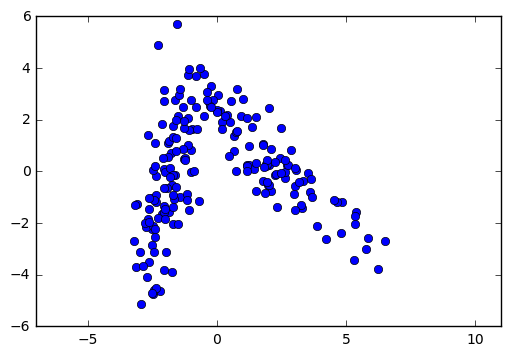

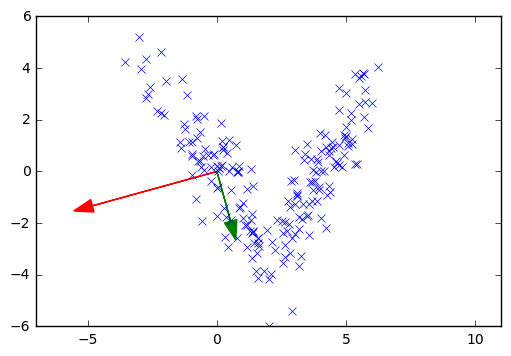

In [122]:
outlier_pt = np.array([[2,-6]]).T
data_outlier = np.hstack(([data,outlier_pt]))
do_PCA(data_outlier)

With just one outlier added to the mix, we have completely changed our principle components. This is why some scientists are, validly, weary of *"machine learning"* as a whole; certain techniques have to be very specifically applied.

However, calling PCA "machine learning" is like calling a tin can a boat; technically not wrong, but misses the point of a boat.

Let's dive into some more advanced approaches.

### Independent Component Analysis
ICA should give us the two components themselves, though since one component is 2d symmetric, not sure what will happen there...

### Gaussian Mixture Models
Gaussian mixture models take in a "number" of gaussians expected in the data, and then does a maximization of likelihood of seeing the data for the underlying model trying to be learned.

GMM should give us the two gaussian! Let's just go for it

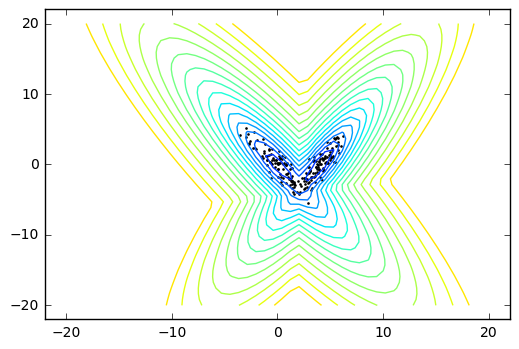

Learned Gaussian Means [[ 0.0564854  -0.12617705]
 [ 4.03946506  0.00777738]]


Learned Gaussian Covariances 
[[[ 1.9077929  -2.61885204]
  [-2.61885204  4.68850886]]

 [[ 1.13171471  1.75956981]
  [ 1.75956981  3.72492203]]]


In [136]:
from sklearn import mixture
from matplotlib.colors import LogNorm

def GMM(data):
    clf = mixture.GaussianMixture(n_components=2,covariance_type='full')
    clf.fit(data.T)

    xd = np.linspace(-20,20)
    yd = np.linspace(-20,20)
    Xd,Yd = np.meshgrid(xd,yd)
    XX = np.array([Xd.ravel(),Yd.ravel()]).T
    Z = -clf.score_samples(XX)
    Z = Z.reshape(Xd.T.shape)

    CS = plt.contour(Xd,Yd,Z,norm=LogNorm(vmin=1.0,vmax=1000),levels=np.logspace(0,2,20))
    plt.scatter(data[0,:],data[1,:],.8)
    plt.axis('equal')
    plt.axis('tight')
    plt.show()
    print('Learned Gaussian Means ' + str(clf.means_) + '\n\n')
    print('Learned Gaussian Covariances \n' + str(clf.covariances_))
    
GMM(data)

Cool! We see what we expect. What happens with the outlier dataset?

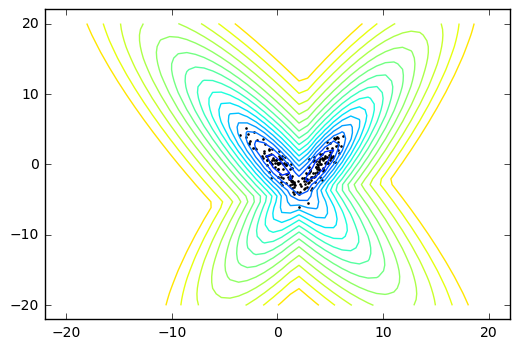

In [125]:
GMM(data_outlier)

Not much is different. Let's look at the learned Gaussians:



In this case, it's a bit trivial, since we know, a priori, that two sources were used to generate the data. The GMM centered two gaussians accordingly to maximize the likelihood of the data being generated. What happens if we change the number of a priori components in the Gaussian Mixture?

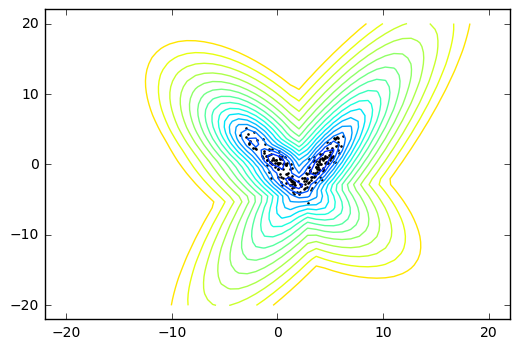

In [124]:
clf = mixture.GaussianMixture(n_components=4,covariance_type='full')
clf.fit(data.T)

xd = np.linspace(-20,20)
yd = np.linspace(-20,20)
Xd,Yd = np.meshgrid(xd,yd)
XX = np.array([Xd.ravel(),Yd.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(Xd.T.shape)

CS = plt.contour(Xd,Yd,Z,norm=LogNorm(vmin=1.0,vmax=1000),levels=np.logspace(0,2,20))
plt.scatter(data[0,:],data[1,:],.8)
plt.axis('equal')
plt.axis('tight')
plt.show()

This is a key consideration of these types of methods; I say, a priori, there are 4 components. The algorithm will *find* four gaussians and mold them to maximize the likelihood of seeing the data. We know this to be *wrong*, but it's a different type of wrong. It's an "overfitting" type of wrong.